# Loading Image Data

In [5]:
# Importing necessary modules
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

2024-08-01 03:09:28.953776: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-01 03:09:29.962641: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-01 03:09:29.988079: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-01 03:09:34.674420: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Unzipping intel image classification dataset
# !unzip -q archive.zip

In [9]:
# Listing directories
!ls

DataLoader.ipynb  train


The image data I am using is the Intel Image Classification dataset from Kaggle. I will be choosing two classes (buildings and forest) from the 'seg_train' directory while discarding the rest of the data.

In [8]:
### Filtering out corrupted images without string 'JFIF' (around 14k images in train)
# num_skipped = 0
# for folder_name in ("buildings", "forest"):
#     max_images = 100
#     folder_path = os.path.join("train", folder_name)
#     for image_i,fname in enumerate(os.listdir(folder_path)):
#         fpath = os.path.join(folder_path, fname)
#         try:
#             fobj = open(fpath, "rb")
#             is_jfif = b"JFIF" in fobj.peek(10)
#         finally:
#             fobj.close()

#         if image_i > max_images or not is_jfif:
#             num_skipped += 1
#             # Delete corrupted image
#             os.remove(fpath)

# print(f"Deleted {num_skipped} images.")

Deleted 4260 images.


In [10]:
# Generating a dataset
image_size = (224, 224)

batch_size = 10

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "train",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 202 files belonging to 2 classes.
Using 162 files for training.
Using 40 files for validation.


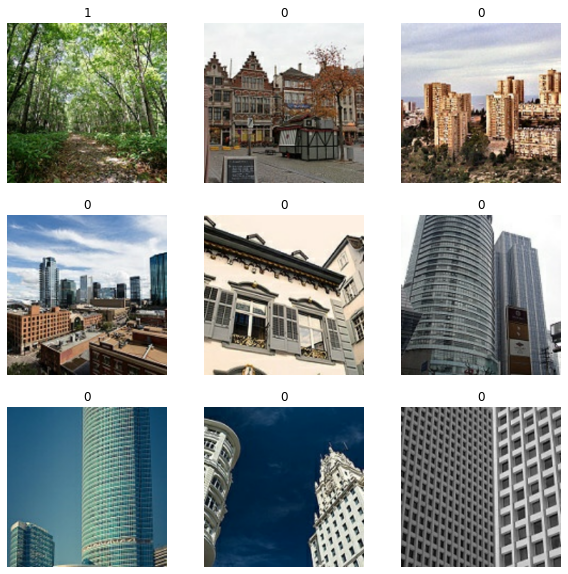

In [11]:
# Visualizing images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [12]:
# Using image data augmentation
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

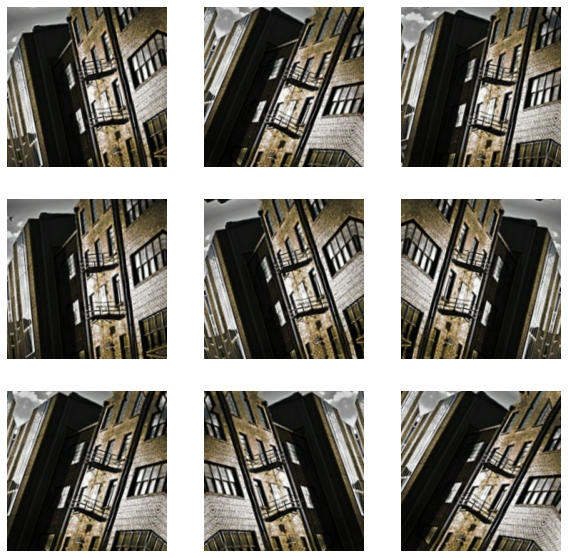

In [13]:
# Visualizing augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [14]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)